/Users/Hatim/anaconda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2821: FutureWarning: The pandas.stats.plm module is deprecated and will be removed in a future version. We refer to external packages like statsmodels, see some examples here: http://www.statsmodels.org/stable/mixed_linear.html
  if self.run_code(code, result):


-----The optimal value of lambda and the corresponding r-square is-----
0.49 0.849689803221


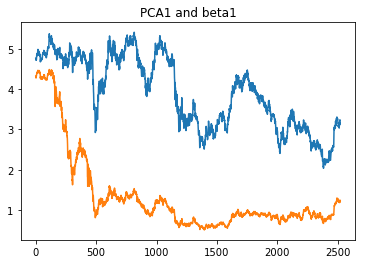

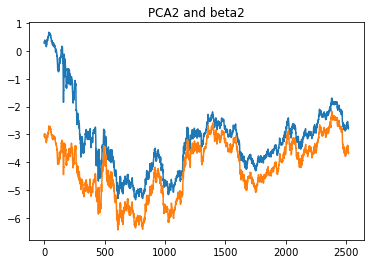

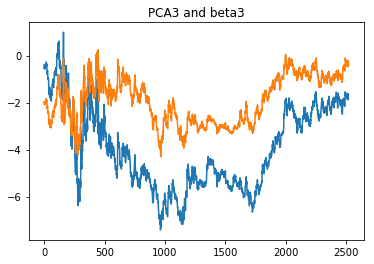

In [5]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas.stats.plm import PanelOLS 

file = "/Users/Hatim/Desktop/CMT-all.xlsx"


def PCA_Function(sample):
    covariance_matrix = np.matrix(sample.cov()) #finding the covariance
    eig_val, eig_vect = np.linalg.eigh(covariance_matrix) #gives in ascending order
    eig_val=eig_val[::-1] #sort descending
    eig_vect=np.fliplr(eig_vect) #sort eigen vectors as per the eigen values 
    L=np.zeros((covariance_matrix.shape[1],covariance_matrix.shape[1]),np.float64) 
    Lsqrt= np.zeros((covariance_matrix.shape[1],covariance_matrix.shape[1]),np.float64)
    np.fill_diagonal(Lsqrt,1/np.sqrt(eig_val))
    np.fill_diagonal(L,np.sqrt(eig_val))
    Z = eig_vect*Lsqrt 
    new_data= np.matrix(sample) * Z
    return pd.DataFrame(new_data),pd.DataFrame(eig_vect)


##Data Import
data = pd.read_excel(file, index_col = 0)
data.index.name = None

#slicing the data for the required dates
data=data.ix['2007-01-01':'2017-04-04',:]


level_data=data

#interpolating the missing data
level_data.interpolate(method='linear',order = 2, axis =  1, inplace=True)

#dropping the NAs if any
level_data=level_data.dropna(how='all')


f1=np.array([1/12,3/12,6/12,1,2,3,5,7,10,20,30],dtype=np.float64) 
 
max_rsquare=0
min_lambda=0
for i in np.arange(0.3,0.7,0.01):
    lam=i
    level_data_stack=pd.DataFrame(level_data.stack())
    k2= (1-np.exp(-lam*f1))/(lam*f1)
    k3= (1-np.exp(-lam*f1))/(lam*f1)-(np.exp(-lam*f1))
    z=np.zeros((11,2))
    z[:,0] = k2
    z[:,1] = k3
    df_fixed=pd.DataFrame(np.tile(z,(level_data.shape[0],1)))
    
    ##Doing the panel OLS##
    
    #setting the same index so that we can concat the two dataframes
    df_fixed.index=level_data_stack.index
    concat_df=pd.concat((level_data_stack,df_fixed),axis=1)
    concat_df.columns=['yield','k2','k3']
    mymod= PanelOLS(y=concat_df['yield'],x=concat_df[['k2','k3']],time_effects=True)
    if(max_rsquare<mymod.r2):
        max_rsquare=mymod.r2
        minlam=lam
opt_lam=minlam

print("-----The optimal value of lambda and the corresponding r-square is-----")
print(minlam,max_rsquare)
 
beta_timeseries=[]
beta_df=pd.DataFrame()

#getting the daily betas
for j in np.arange(0,concat_df.shape[0],11):
    concat_df['intercept']=np.ones(concat_df.shape[0])
    modelyc= sm.OLS(concat_df.ix[j:j+11,'yield'],concat_df.ix[j:j+11,['k2','k3','intercept']]).fit()
    lst=[modelyc.params[2],modelyc.params[0],modelyc.params[1]]
    beta_timeseries.append(lst)
    beta_df=pd.DataFrame(beta_timeseries)


new_data, pca =PCA_Function(data)

plt.plot(beta_df[0])
plt.plot(1*new_data[0])
plt.title("PCA1 and beta1")
plt.show()

plt.plot(beta_df[1])
plt.plot(-1*new_data[1])
plt.title("PCA2 and beta2")
plt.show()
plt.plot(beta_df[2])
plt.plot(-1*new_data[2])
plt.title("PCA3 and beta3")
plt.show()